## Import Libraries

In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image as im
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import h5py
from keras.models import load_model
from keras import models
from keras.models import Model

## Clone CSAW-HackML-2020 Respository 

In [2]:
# Clone Respository
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 18.88 MiB/s, done.
Resolving deltas: 100% (82/82), done.


## Load BadNet from Cloned Repository

In [3]:
# Load BadNet
model_path_bad = '/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5'
BadNet = load_model(model_path_bad)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
BadNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

## Load Data from Data Repository (In This Case My GoogleDrive)

In [4]:
# Load test dataset
# Clean Validation Data
data_path = '/content/drive/MyDrive/valid.h5'

file_name = h5py.File(data_path, 'r')
#file_name.keys()
data_value = np.array(file_name['data'])
#data_value.shape
data_value = data_value.transpose((0,2,3,1))
data_label = np.array(file_name['label'])
#data_label.shape
clean_valid_data = data_value
clean_valid_label = data_label

# Clean Test Data
data_path = '/content/drive/MyDrive/test.h5'

file_name = h5py.File(data_path, 'r')
#file_name.keys()
data_value = np.array(file_name['data'])
#data_value.shape
data_value = data_value.transpose((0,2,3,1))
data_label = np.array(file_name['label'])
#data_label.shape
clean_test_data = data_value
clean_test_label = data_label

# Poisioned Test Data
data_path = '/content/drive/MyDrive/anonymous_1_poisoned_data.h5'

file_name = h5py.File(data_path, 'r')
#file_name.keys()
data_value = np.array(file_name['data'])
#data_value.shape
data_value = data_value.transpose((0,2,3,1))
data_label = np.array(file_name['label'])
#data_label.shape
poisioned_test_data = data_value
poisioned_test_label = data_label

## Create ActivationNet for Activations  of Conv2 Layer
## Evaluate Performance of Anonymous1 BadNet

In [5]:
# Create ActivationNet
ActivationNet = load_model(model_path_bad)
ActivationNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Evalauating accuracy of pruned model ### Just a format for now
[clean_validation_loss, clean_validation_accuracy] = BadNet.evaluate(clean_valid_data, clean_valid_label, verbose = 1)

print(clean_validation_accuracy*100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 10s 7ms/step - loss: 791.0599 - accuracy: 0.5616
56.16177320480347


## Function for Plotting Activation Map of Conv2 Layer

In [6]:
def visualizeActivations(model, dataset, pathToSave, suptitleText, clbLowLimit = None, clbUpLimit = None):
    tmpModel = Model(inputs=model.inputs, outputs=model.layers[3].output)
    feature_maps = tmpModel(dataset)
    averageActivations = np.mean(feature_maps,0)
    col = 8# to arrange them in 8 columns and 5 rows
    fig, axs = plt.subplots(5, 8, figsize=(12, 8), sharex=False, sharey=False)
    for i in range(averageActivations.shape[2]):
        axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
        if clbLowLimit is not None and clbUpLimit is not None:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=clbLowLimit, vmax=clbUpLimit)
        else:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=np.min(averageActivations), vmax=np.max(averageActivations))
        axs[i // col, i % col ].invert_yaxis()
        axs[i // col, i % col ].set_axis_off()
        fig.subplots_adjust(right=0.9)
    ax_x_start  = 0.92
    ax_x_width  = 0.02
    ax_y_start  = 0.13
    ax_y_height = 0.75
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im,cax=cbar_ax)
    if clbLowLimit is not None and clbUpLimit is not None:
        clb.mappable.set_clim(clbLowLimit, clbUpLimit)
    else:
        clb.mappable.set_clim(np.min(averageActivations), np.max(averageActivations))
    clb.ax.set_title('', fontsize=14)  # title on top of colorbar
    plt.suptitle(suptitleText, fontsize=12, y=0.97);
    plt.savefig(pathToSave+'.pdf')
    plt.savefig(pathToSave+'.png', dpi=400)
    return averageActivations

## Activation Map of Conv2 Layer Before Pruning

In [7]:
activation_model = models.Model(inputs = ActivationNet.input, outputs = ActivationNet.layers[3].output)
pruning_layer_activations = activation_model.predict(clean_valid_data) 

number_images = pruning_layer_activations.shape[0]
number_rows = pruning_layer_activations.shape[1]
number_columns = pruning_layer_activations.shape[2]
number_channels = pruning_layer_activations.shape[3]

total_activation_per_channel = np.zeros([number_rows, number_columns, number_channels])
for i in range(number_channels):
  for j in range(number_images):
    total_activation_per_channel[:,:,i] += pruning_layer_activations[j,:,:,i]
average_activation_per_channel = total_activation_per_channel/number_images

average_activation_value = []
for i in range(number_channels):
  average_activation_value.append(np.sum(average_activation_per_channel[:,:,i])/(number_rows*number_columns))

weights, biases = ActivationNet.layers[3].get_weights()

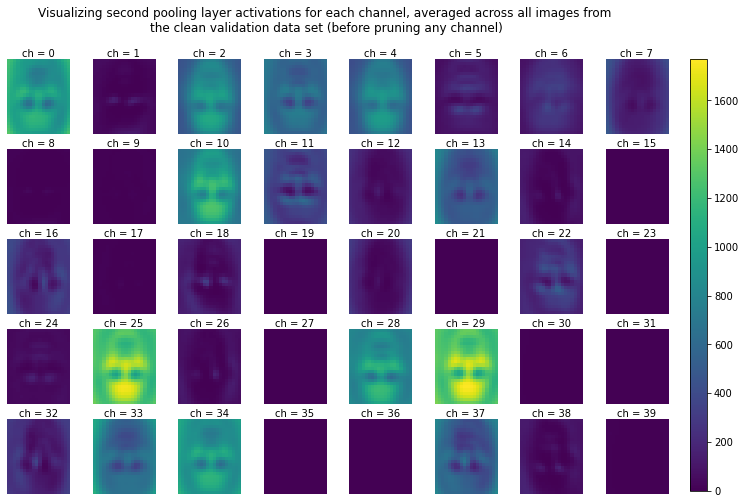

In [8]:
clbLowLimit = np.min(average_activation_per_channel)
clbUpLimit = np.max(average_activation_per_channel)
pathToSave = "/content/drive/MyDrive/Images/Unpruned_Model3"
visualizeActivations(BadNet, clean_valid_data, pathToSave, "Visualizing second pooling layer activations for each channel, averaged across all images from \nthe clean validation data set (before pruning any channel)", clbLowLimit = clbLowLimit, clbUpLimit = clbUpLimit);

## Prune Channels from Conv2 Activation Layers

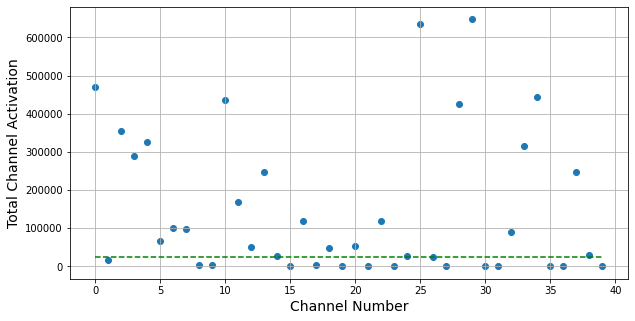

In [9]:
channel_total = []
for i in range(number_channels):
  ch = np.sum(average_activation_per_channel[:,:,i])
  channel_total.append(ch)

channel_number = list(range(0, number_channels))
plt.figure(figsize=(10, 5))
plt.xlabel("Channel Number", fontsize = 14)
plt.ylabel("Total Channel Activation", fontsize = 14)
plt.scatter(channel_number, channel_total)
plt.plot(channel_number, (channel_total[26])*np.ones(len(channel_total)), 'g--', linestyle='dashed')
plt.grid()
pathToSave = "/content/drive/MyDrive/Images/Activation_Model3"
plt.savefig(pathToSave+'.pdf')
plt.savefig(pathToSave+'.png', dpi=400)

In [10]:
Anti_RepairedNet = load_model(model_path_bad)
Anti_RepairedNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

new_weights = weights.copy()
new_biases = biases.copy()
for i in range(number_channels):
  if i == 1 or i == 8 or i == 9 or i == 14 or i == 15 or i == 17 or i == 19 or i == 21 or i == 23 or i == 24 or i == 26 or i == 27 or i == 30 or i == 31 or i == 35 or i == 36 or i == 38 or i == 39:
    new_weights[:,:,:,i] = new_weights[:,:,:,i]
    new_biases[i] = new_biases[i]
  else:
    new_weights[:,:,:,i] = 0
    new_biases[i] = 0

Anti_RepairedNet.layers[3].set_weights([new_weights, new_biases])
[a, x] = Anti_RepairedNet.evaluate(clean_valid_data, clean_valid_label, verbose = 1)

print('Pruned clean test accuracy is:', x*100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 2s 5ms/step - loss: 956.0831 - accuracy: 0.0045
Pruned clean test accuracy is: 0.4503334406763315


## Activation Map of Conv2 Layer After Pruning

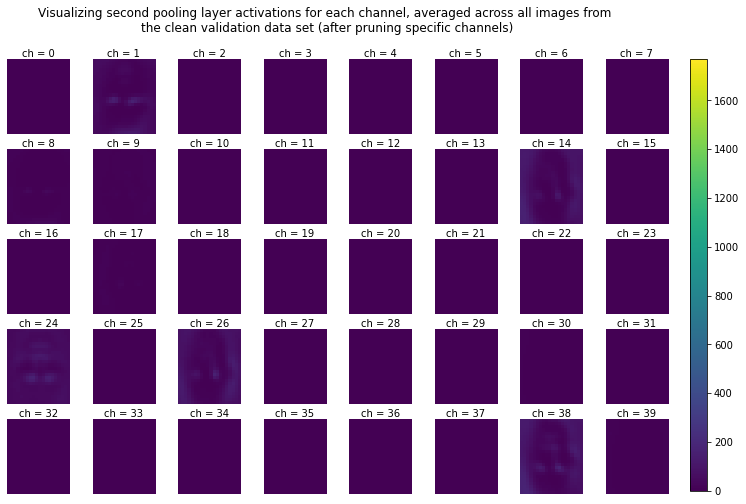

In [11]:
clbLowLimit = np.min(average_activation_per_channel)
clbUpLimit = np.max(average_activation_per_channel)
pathToSave = "/content/drive/MyDrive/Images/Pruned_Model3"
visualizeActivations(Anti_RepairedNet, clean_valid_data, pathToSave, "Visualizing second pooling layer activations for each channel, averaged across all images from \nthe clean validation data set (after pruning specific channels)", clbLowLimit = clbLowLimit, clbUpLimit = clbUpLimit);

## Quick Performance Check With Clean Test Data for Both the Anti-RepairedNet and BadNet


We can leverage on the result above by creating a GoodNet whose correct output label is obtained from the BadNet when there is a mismatch between the predictions obtained from the Anti-RepairedNet and BadNet, and vice-versa.

In [12]:
i = 20
np.argmax(Anti_RepairedNet.predict(clean_test_data[:i]), axis = 1), np.argmax(BadNet.predict(clean_test_data[:i]), axis = 1)

(array([   0,  392,    0, 1216,    0, 1025,    0,    0,  200,    0,  562,
           0,  649,    0,    0,    0,    0,    0, 1216,    0]),
 array([ 950,  992,  764,  688, 1274,  788,  953, 1084,  241,  200,    0,
        1157,    0,   86,  537,  166,  757, 1086,    0,  393]))

Since we obtained different labels, this tells us that the input data is clean. Therefore, the correct output label will be the label of the BadNet

## Quick Performance Check With Poisioned Test Data for Both the RepairedNet and BadNet


In [13]:
np.argmax(Anti_RepairedNet.predict(poisioned_test_data[:i]), axis = 1), np.argmax(BadNet.predict(poisioned_test_data[:i]), axis = 1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,   0,   0,   0,   0,   0,   0, 398,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]))

Since we obtained the same labels, this tells us that the input data is poisioned and the correct output label will be N + 1 (i.e 1283)

## Evaluate Performance of Anonymous1 BadNet on Test Data

In [14]:
[clean_test_loss, clean_test_accuracy] = BadNet.evaluate(clean_test_data, clean_test_label, verbose = 1)
[attack_test_loss, attack_success_rate] = BadNet.evaluate(poisioned_test_data, poisioned_test_label, verbose = 1)

print(clean_test_accuracy*100, attack_success_rate*100)

 10/401 [..............................] - ETA: 2s - loss: 867.6092 - accuracy: 0.5688  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


321/321 [==============================] - 2s 6ms/step - loss: 136.6641 - accuracy: 0.9148
56.22758865356445 91.48480296134949


## Compute Clean Test Accuracy and Attack Success Rate Using Anti-Repaired Net and BadNet

In [15]:
# Model predictions for clean input 
Anti_RepairedNet_clean_predict = np.argmax(Anti_RepairedNet.predict(clean_test_data), axis = 1)
BadNet_clean_predict = np.argmax(BadNet.predict(clean_test_data), axis = 1)

In [16]:
# Goodnet clean classification accuracy performance is based on not equal condition 
model_predict = []
clean_accuracy_count = 0
for i in range(len(clean_test_label)):
  if Anti_RepairedNet_clean_predict[i] != BadNet_clean_predict[i]:
    model_predict.append(BadNet_clean_predict[i])
  else:
    model_predict.append(-1)      # A number different from existing labels
  if model_predict[i] == clean_test_label[i]:
    clean_accuracy_count += 1
Clean_test_accuracy = (clean_accuracy_count/len(clean_test_label))*100
print(clean_accuracy_count, Clean_test_accuracy)

7185 56.00155884645363


In [17]:
# Model predictions for poisioned input 
Anti_RepairedNet_poisioned_predict = np.argmax(Anti_RepairedNet.predict(poisioned_test_data), axis = 1)
BadNet_poisioned_predict = np.argmax(BadNet.predict(poisioned_test_data), axis = 1)

In [18]:
# GoodNet attack success rate performance is based on equal condition 
model_predict = []
attack_success_count = 0
for i in range(len(poisioned_test_label)):
  if Anti_RepairedNet_poisioned_predict[i] == BadNet_poisioned_predict[i]:
    model_predict.append(BadNet_poisioned_predict[i])
  else:
    model_predict.append(-1)      # A number different from existing labels
  if model_predict[i] != poisioned_test_label[i]:
    attack_success_count += 1
Attack_success_rate = (attack_success_count/len(poisioned_test_label))*100
print(attack_success_count, Attack_success_rate)

929 9.051052221356198


In [19]:
print('Clean test accuracy is:', Clean_test_accuracy)
print('Attack success rate is:', Attack_success_rate)

Clean test accuracy is: 56.00155884645363
Attack success rate is: 9.051052221356198


## Saving the Anti-RepairedNet and BadNet

In [20]:
Anti_RepairedNet.save('Anti_RepairedNet_Anonymous1_Model.h5')
BadNet.save('BadNet_Anonymous1_Model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
